# Creating prior knowledge masks (Penumbra & Core)
Penumbra and Core are known at time of acute imaging and are essential components to the final infarct. Integrating these priors in a model could yield better results.

One Perfusion imaging:
- Penumbra is defined with Tmax > 6s
- Core is defined as rCBF < 30%

In [22]:
import sys, os
sys.path.insert(0, '../')
import numpy as np
from gsprep.visual_tools.visual import display, idisplay
from gsprep.visual_tools.dataset_visualization import visualize_dataset
from gsprep.visual_tools.dataset_histograms import plot_per_sample_histograms, plot_histogram
from scipy.ndimage.filters import gaussian_filter
import scipy.ndimage.morphology as ndimage
from skimage.morphology import ball

In [24]:
dataset_path = "../../data/working_data/clean_data_set_with_ncct.npz"
n_subj = 144

raw_images = np.load(dataset_path, allow_pickle=True)['ct_inputs'][:n_subj].astype(np.float64)
try:
    raw_labels = np.load(dataset_path, allow_pickle=True)['ct_lesion_GT'].astype(np.float64)
except:
    raw_labels = np.load(dataset_path, allow_pickle=True)['lesion_GT'].astype(np.float64)
# raw_labels = np.load(dataset_path, allow_pickle=True)['lesion_GT'][:n_subj].astype(np.float64)
raw_mask = np.load(dataset_path, allow_pickle=True)['brain_masks'][:n_subj]
params = np.load(dataset_path, allow_pickle=True)['params']

n_subj, n_x, n_y, n_z, n_c = raw_images.shape
raw_images.shape

(140, 79, 95, 79, 5)

Define helper functions



In [25]:
def gaussian_smoothing(data, kernel_width=5, threeD=False):
    '''
    Smooth a set of n images with a 2D gaussian kernel on their x, y planes iterating through z
    if threeD is set to false; Every plane in z is smoothed independently
    Every channel is smoothed independently
    :param data: images to smooth (n, x, y, z, c)
    :param kernel_width: 2D or 3D kernel width
        Default width is 5 vxl - (stroke dataset: 10mm width), ie. 5mm radius as inspired by
        Campbell Bruce C.V., Christensen Søren, Levi Christopher R., Desmond Patricia M., Donnan Geoffrey A., Davis Stephen M., et al. Cerebral Blood Flow Is the Optimal CT Perfusion Parameter for Assessing Infarct Core. Stroke. 2011 Dec 1;42(12):3435–40.
    :param threeD, default False: exert smoothing in all 3 spatial dimensions and not only 2
    :return: smoothed_data
    '''
    if len(data.shape) != 5:
        raise ValueError('Shape of data to smooth should be (n, x, y, z, c) and not', data.shape)

    sigma = kernel_width / 3
    truncate = ((kernel_width - 1) / 2 - 0.5) / sigma
    smoothed_data = np.empty(data.shape)

    for i in range(data.shape[0]):
        for c in range(data.shape[4]):
            if not threeD:
                for z in range(data.shape[3]):
                    smoothed_data[i, :, :, z, c] = gaussian_filter(data[i, :, :, z, c], kernel_width / 3,
                                                                   truncate=truncate)
            else:
                smoothed_data[i, :, :, :, c] = gaussian_filter(data[i, :, :, :, c], kernel_width/3, truncate=truncate)

    return smoothed_data


def normalise_by_contralateral_median(data):
    '''
    Normalise an image by dividing every voxel by the median voxel value of the contralateral side
    :param data: image input data for all subjects in form of an np array [n_subj, x, y, z, c]
    :return: normalised array
    '''

    normalised_data = np.empty(data.shape)

    for subj in range(data.shape[0]):
        subj_data = data[subj]
        subj_normalised_data = subj_data.copy()
        x_center = subj_data.shape[0] // 2
        left_side_set_off = x_center
        if subj_data.shape[0] % 2 == 0:
            # if number voxels along x is even, split in the middle
            right_side_set_off = x_center
        else:
            # if number voxels along x is uneven leave out the middle voxel line
            right_side_set_off = x_center + 1

        # normalise left side
        right_side = subj_data[right_side_set_off:]
        right_side_median = np.median(right_side[np.nonzero(right_side)])
        subj_normalised_data[:left_side_set_off] = np.divide(subj_data[:left_side_set_off], right_side_median)

        # normalise right side
        left_side = subj_data[:left_side_set_off]
        left_side_median = np.median(left_side[np.nonzero(left_side)])
        subj_normalised_data[right_side_set_off:] = np.divide(subj_data[right_side_set_off:], left_side_median)

        if subj_data.shape[0] % 2 != 0:
            x_para_median_slices_mean = np.mean([
                                            np.mean(subj_data[x_center - 1][np.nonzero(subj_data[x_center - 1])]),
                                            np.mean(subj_data[x_center + 1][np.nonzero(subj_data[x_center + 1])])
                                        ])
            subj_normalised_data[x_center] = np.divide(subj_data[x_center], x_para_median_slices_mean)

        normalised_data[subj] = subj_normalised_data

    return normalised_data

## Create CSF mask

As false negative CSF masks can be harmful to the model, a safety margins is added and the csf mask is enlarged.

In [26]:
ncct_channel = 4
threshold = 20
csf_mask = gaussian_smoothing(raw_images[..., ncct_channel, None], kernel_width=3) < threshold
enlarged_csf_mask = np.array([ndimage.binary_dilation(csf_mask[idx, ..., 0], structure=ball(2)) for idx in range(csf_mask.shape[0])])
inv_csf_mask = -1 * enlarged_csf_mask + 1
inv_csf_mask.shape

(140, 79, 95, 79)

Image center:  39 47 39
Image center value:  26.0


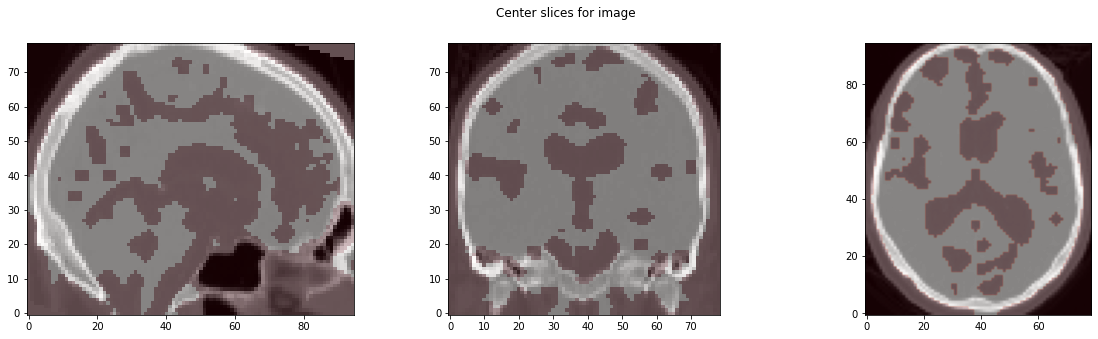

In [27]:
display(raw_images[0, ..., 4], mask=enlarged_csf_mask[0])

## Create skull mask

Better way: Use gsprep skull_stripping

In [28]:
ncct_channel = 4
threshold = np.percentile(raw_images[..., ncct_channel], 90)
skull_mask = gaussian_smoothing(raw_images[..., ncct_channel, None], kernel_width=3) > threshold
enlarged_skull_mask = np.array([ndimage.binary_dilation(skull_mask[idx, ..., 0], structure=ball(2)) for idx in range(skull_mask.shape[0])])
inv_skull_mask = -1 * enlarged_skull_mask + 1

Image center:  39 47 39
Image center value:  26.0


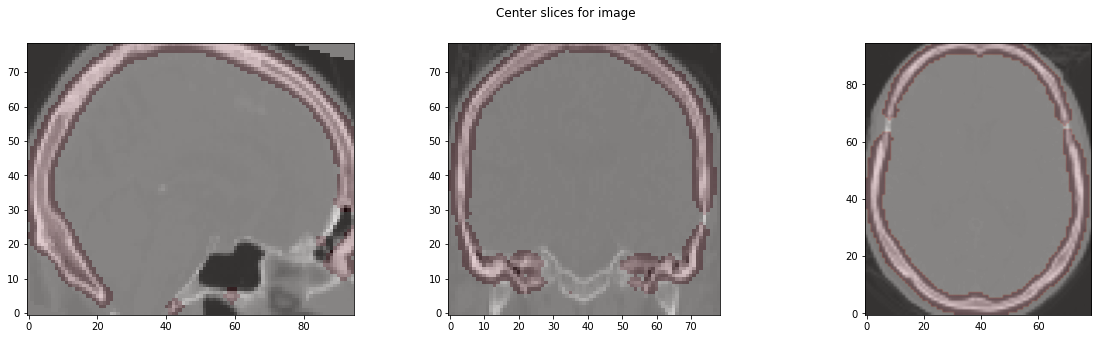

In [29]:
display(raw_images[0, ..., 4], mask=enlarged_skull_mask[0])

## Create major vessel mask

Major vessels create false positive signal on Tmax masks, but are easily recognisable on CBF

Better way to do this: Segment on VPCT?

In [30]:
cbf_channel = 1
threshold = np.percentile(raw_images[..., cbf_channel], 99)
vessel_mask = raw_images[..., cbf_channel] > threshold
enlarged_vessel_mask = np.array([ndimage.binary_dilation(vessel_mask[idx], structure=ball(2)) for idx in range(vessel_mask.shape[0])])
vessel_mask = enlarged_vessel_mask
inv_vessel_mask = -1 * vessel_mask + 1

Image center:  39 47 39
Image center value:  151.72999660857022


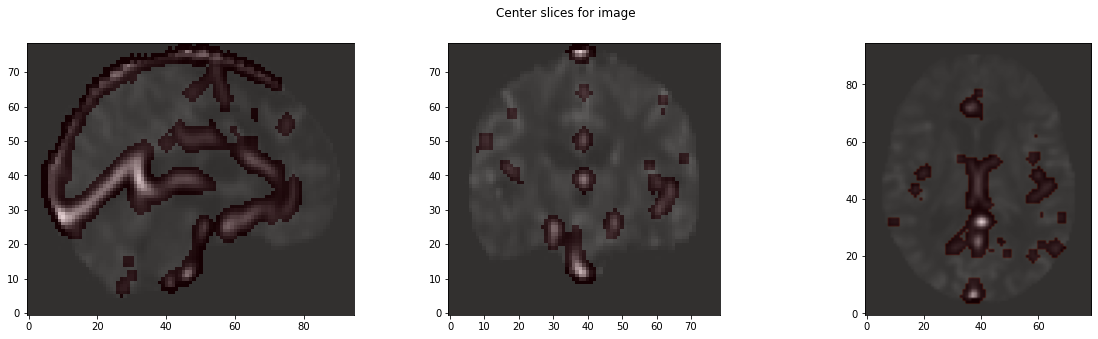

Image center:  39 47 39
Image center value:  True


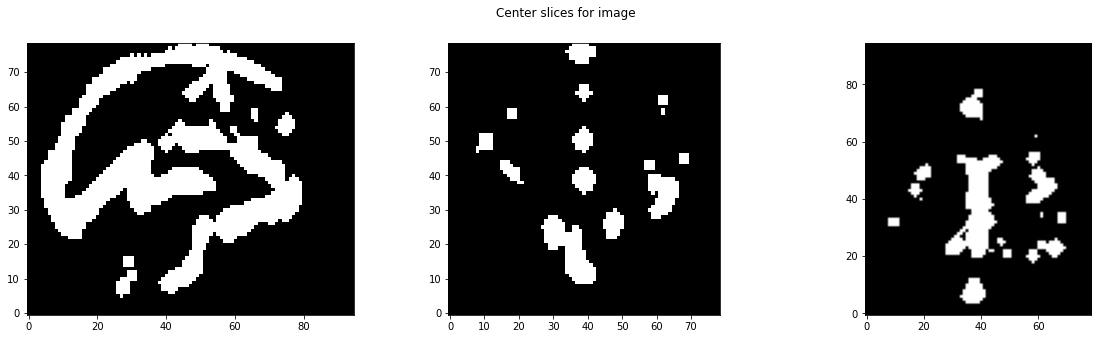

In [31]:
subj_idx = 1
display(raw_images[subj_idx,...,cbf_channel], mask=vessel_mask[subj_idx])
display(vessel_mask[subj_idx])

## Create Penumbra mask

In [32]:
raw_penumbra_masks = raw_images[..., 0] > 6
smooth_penumbra_masks = gaussian_smoothing(raw_images[..., 0, None], kernel_width=3) > 6
corr_csf_penumbra_masks = smooth_penumbra_masks * inv_csf_mask[..., None] # correct for CSF
corr_vx_penumbra_masks = corr_csf_penumbra_masks * inv_vessel_mask[..., None] # correct for CSF
# Todo correct for vessels

Image center:  39 47 39
Image center value:  True


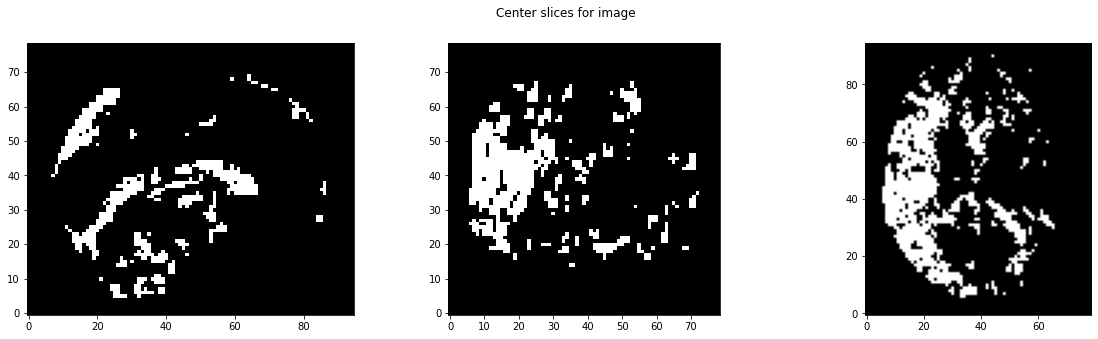

Image center:  39 47 39
Image center value:  False


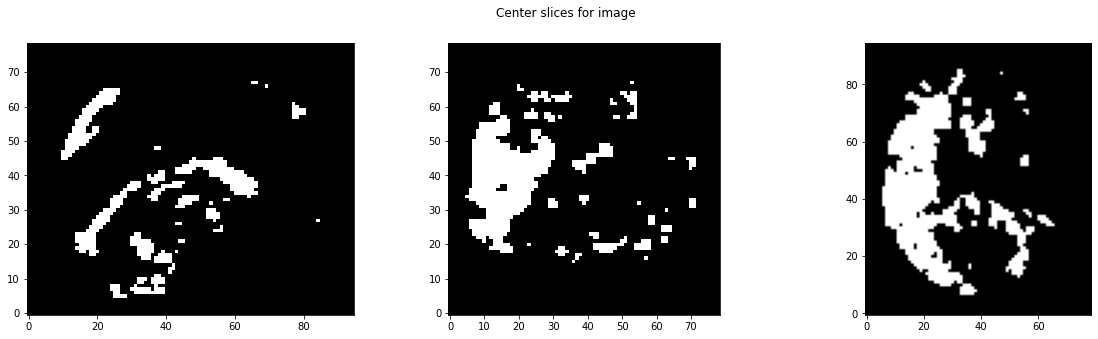

Image center:  39 47 39
Image center value:  0


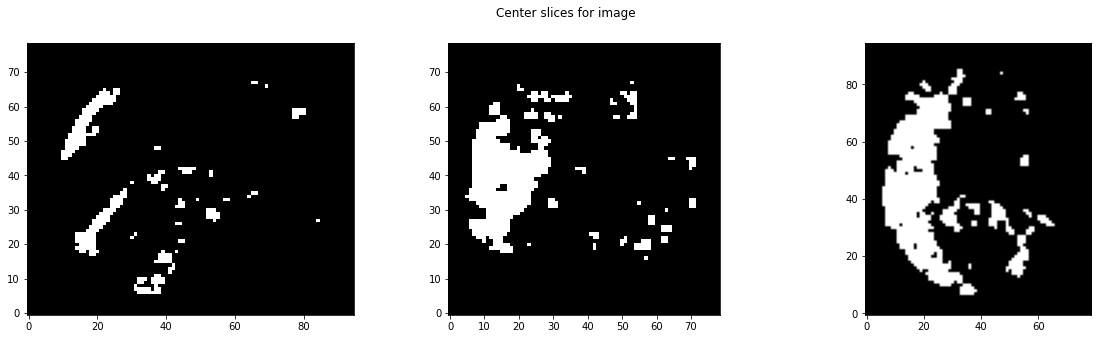

Image center:  39 47 39
Image center value:  0


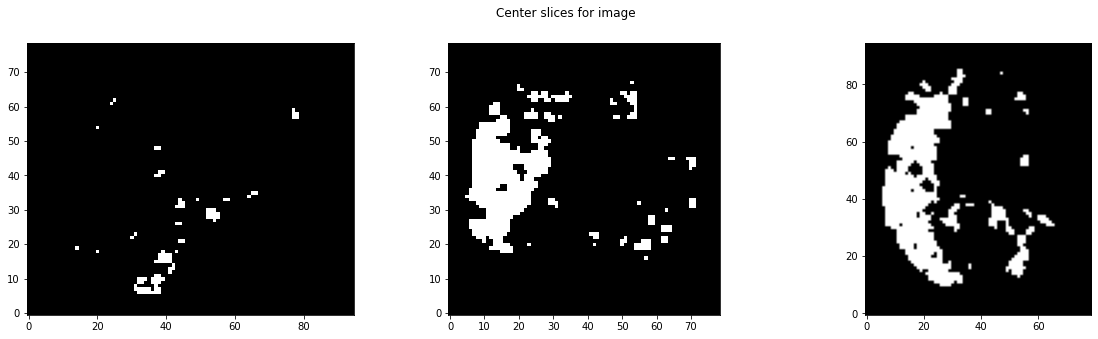

Image center:  39 47 39
Image center value:  6.049999864771962


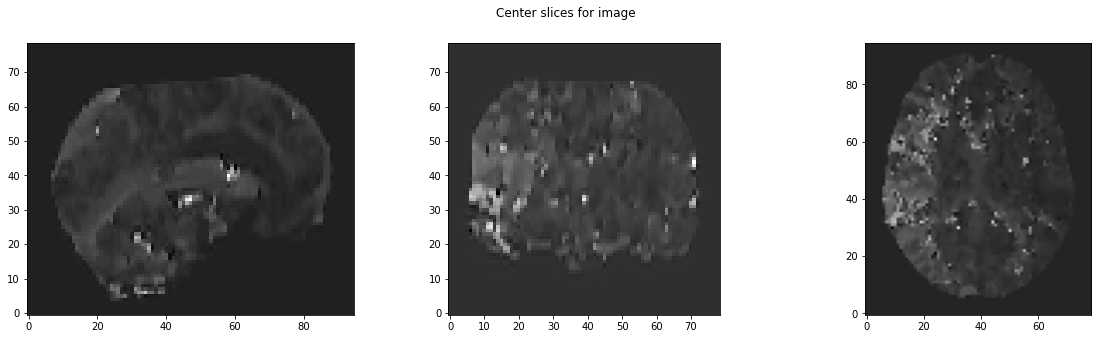

In [33]:
subj_idx = 5
display(raw_penumbra_masks[subj_idx])
display(smooth_penumbra_masks[subj_idx])
display(corr_csf_penumbra_masks[subj_idx, ..., 0])
display(corr_vx_penumbra_masks[subj_idx, ..., 0])
display(raw_images[subj_idx, ..., 0])


## Create Core mask



In [34]:
rCBF = normalise_by_contralateral_median(raw_images[..., 1])
smooth_rCBF = normalise_by_contralateral_median(gaussian_smoothing(raw_images[..., 1, None], kernel_width=2))
raw_core_masks = rCBF < 0.38
smooth_core_masks = smooth_rCBF < 0.38
corr_csf_core_masks = smooth_core_masks * inv_csf_mask[..., None]
corr_vx_core_masks = corr_csf_core_masks * inv_vessel_mask[..., None]
corr_skull_core_masks = corr_vx_core_masks * inv_skull_mask[..., None]

Image center:  39 47 39
Image center value:  124.6999972127378


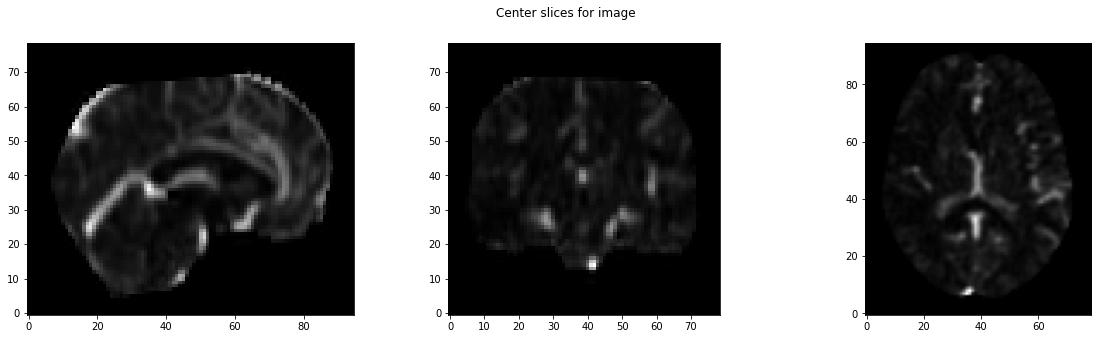

Image center:  39 47 39
Image center value:  False


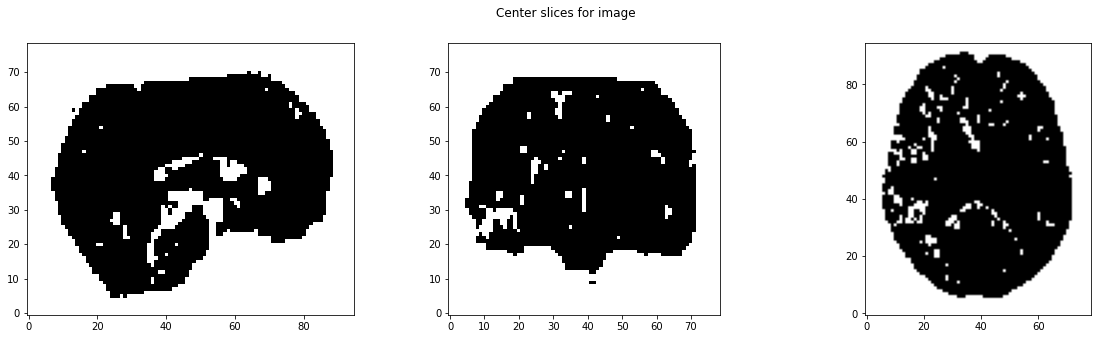

Image center:  39 47 39
Image center value:  False


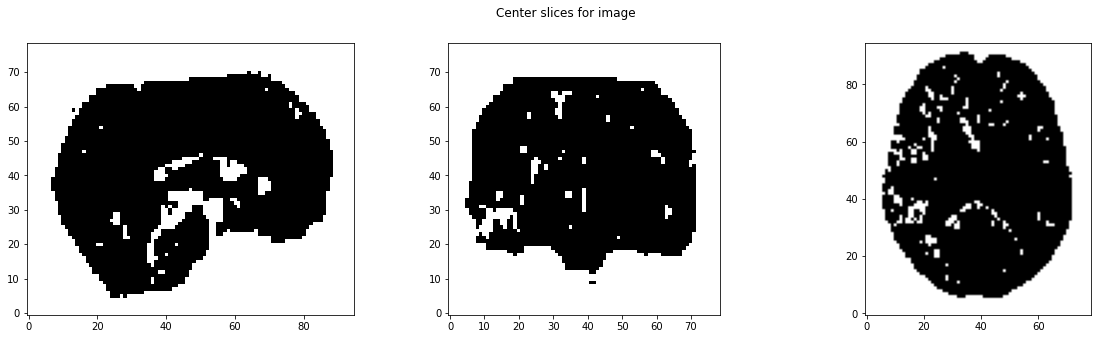

Image center:  39 47 39
Image center value:  0


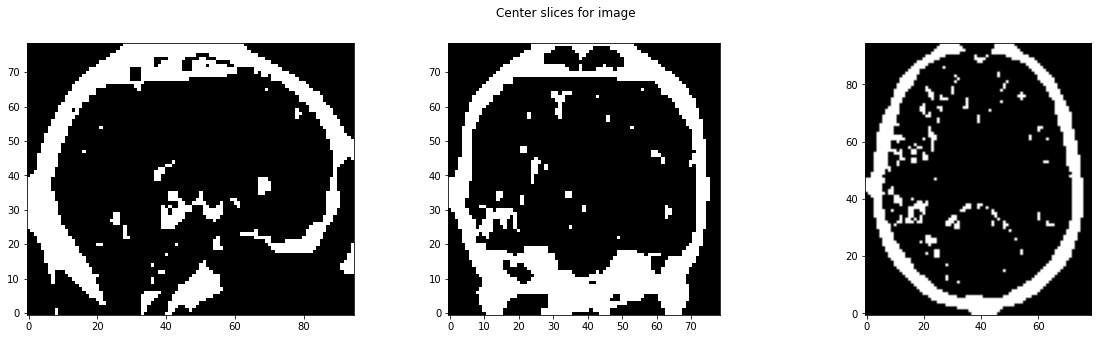

Image center:  39 47 39
Image center value:  0


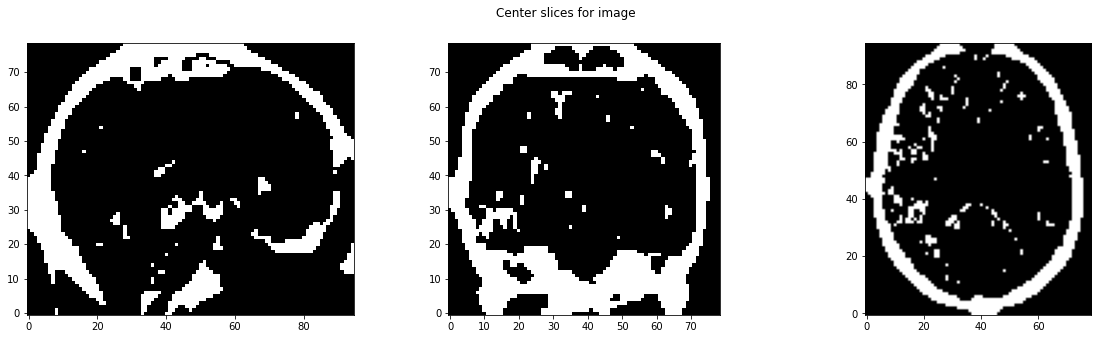

Image center:  39 47 39
Image center value:  0


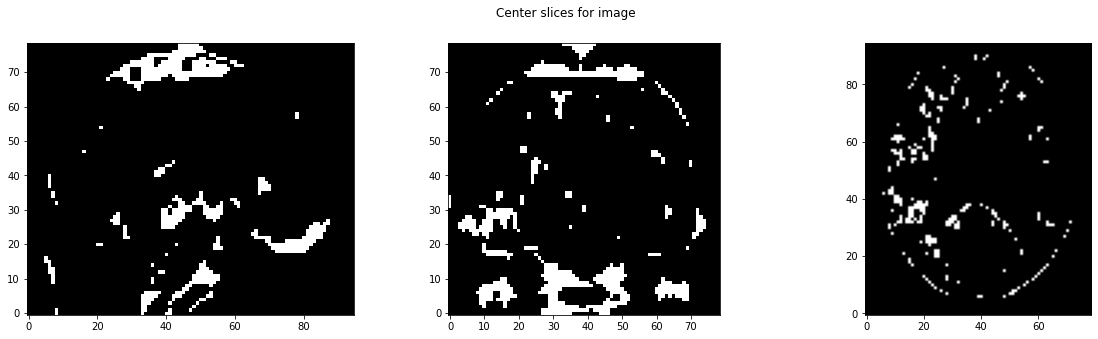

Image center:  39 47 39
Image center value:  6.049999864771962


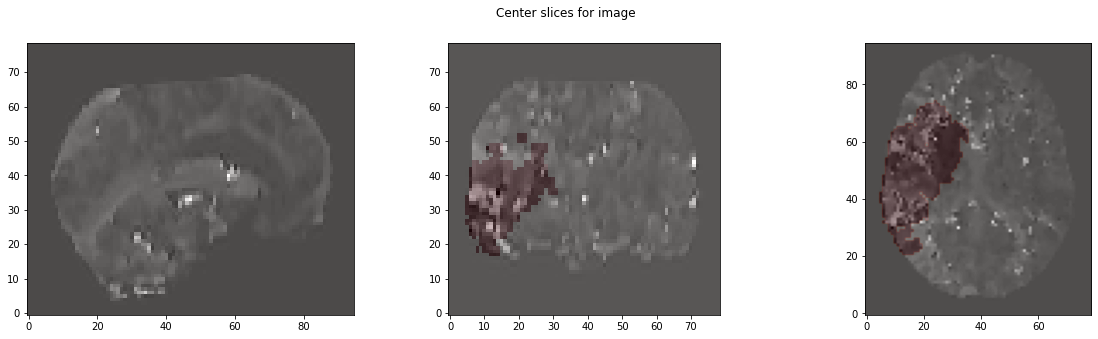

In [35]:
subj_idx = 5
display(raw_images[subj_idx, ..., 1])
display(raw_core_masks[subj_idx])
display(smooth_core_masks[subj_idx])
display(corr_csf_core_masks[subj_idx])
display(corr_vx_core_masks[subj_idx])
display(corr_skull_core_masks[subj_idx])
display(raw_images[subj_idx, ...,0], mask=raw_labels[subj_idx])

Restrict to defined brain mask


In [36]:
restr_core = corr_skull_core_masks * raw_mask[..., None]
restr_penumbra = corr_vx_penumbra_masks * raw_mask[..., None]

Image center:  39 47 39
Image center value:  7.299999836832285


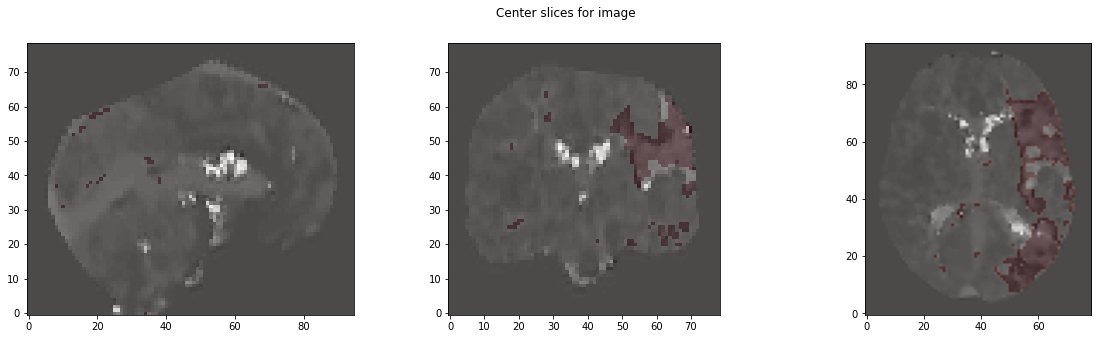

Image center:  39 47 39
Image center value:  7.299999836832285


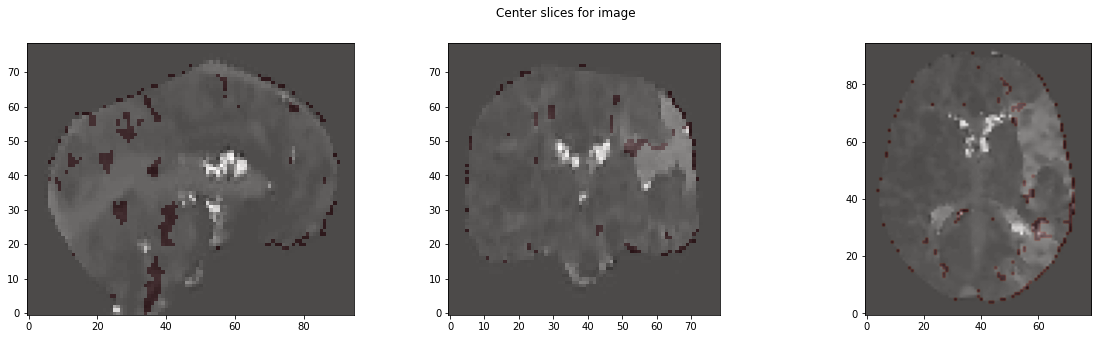

Image center:  39 47 39
Image center value:  0.0


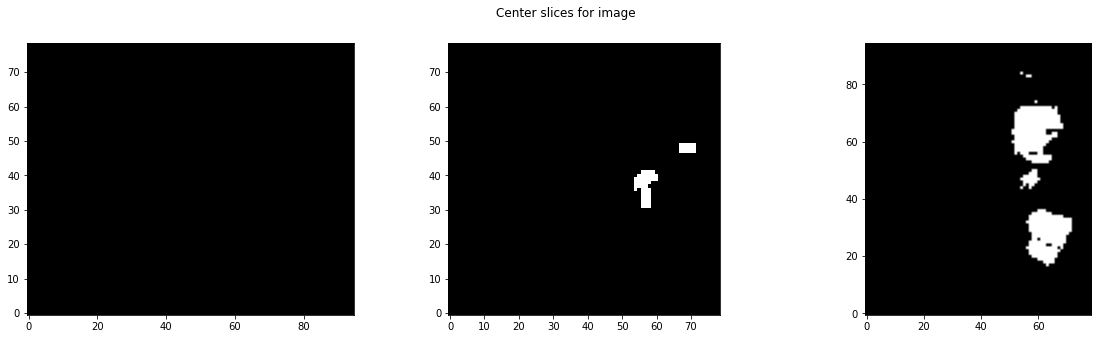

In [37]:
subj_idx = 60
display(raw_images[subj_idx, ...,0], mask=restr_penumbra[subj_idx])
display(raw_images[subj_idx, ...,0], mask=restr_core[subj_idx])
display(raw_labels[subj_idx])


Stats


In [38]:
# GT in penumbra
np.sum(restr_penumbra[..., 0] * raw_labels) / np.sum(raw_labels)


0.5843170950388523

In [39]:
# Core in GT
np.sum(restr_core[..., 0] * raw_labels) / np.sum(restr_core)



0.0981296012556523

In [41]:
restr_penumbra.shape

(140, 79, 95, 79, 1)

# Save Tmax, CBF and brain_mask as input

In [46]:
raw_images.shape

(140, 79, 95, 79, 5)

In [47]:
raw_mask.shape

(140, 79, 95, 79)

In [48]:
clean_tmax_cbf_brain_images = np.zeros(raw_images[..., 0].shape+(3,)).astype(np.float64)
clean_tmax_cbf_brain_images[...,0] = raw_images[..., 0] # Tmax
clean_tmax_cbf_brain_images[...,1] = raw_images[..., 1] # CBF
clean_tmax_cbf_brain_images[...,2] = raw_mask

In [49]:
clean_tmax_cbf_brain_images.shape

(140, 79, 95, 79, 3)

# Save lesion, penumbra and core

In [42]:
np.zeros(restr_penumbra[..., 0].shape+(3,)).astype(np.float64).shape

(140, 79, 95, 79, 3)

In [43]:
raw_labels.shape

(140, 79, 95, 79)

In [45]:
clean_lesion_pen_core_GT = np.zeros(restr_penumbra[..., 0].shape+(3,)).astype(np.float64)
clean_lesion_pen_core_GT[...,0] = raw_labels
clean_lesion_pen_core_GT[...,1] = restr_penumbra[..., 0]
clean_lesion_pen_core_GT[...,2] = restr_core[..., 0]

In [50]:
clean_lesion_pen_core_GT.shape

(140, 79, 95, 79, 3)

# Save Everything

In [52]:
original_data = np.load(dataset_path, allow_pickle=True)

In [53]:
already_saved = False
if not already_saved:
    np.savez_compressed('clean_3_inputs_3_masks_data_set', 
             params=original_data['params'], 
             ids=original_data['ids'], 
             included_subjects=original_data['included_subjects'], 
             clinical_inputs=original_data['clinical_inputs'], 
             ct_inputs=clean_tmax_cbf_brain_images, 
             lesion_GT=clean_lesion_pen_core_GT, 
             brain_masks=original_data['brain_masks'])